In [1]:
import pandas as pd

In [2]:
df_test = pd.read_csv("/mnt/nfs/wangd/DeepLC/non.csv")
df_test.sort_values("tr",inplace=True)
#df_test.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
df_test = df_test.groupby(["seq","modifications"], as_index=False).median()

In [3]:
df_test

,seq,modifications,tr
0,AAANFFSASCVPCADQSSFPK,0|TMT6plex|10|Carbamidomethyl|13|Carbamidometh...,3495.2000
1,AAATVAGKWR,8|TMT6plex,5334.7000
2,AACPGPMTF,0|TMT6plex|3|Carbamidomethyl,252.7000
3,AAHTAHSLK,0|Acetyl|9|TMT6plex,186.4000
4,AAILVTPLLK,0|TMT6plex|10|TMT6plex,3375.4000
...,...,...,...
1379,YVQIGSDSRDGKCLYEKCLGSDPKWEYSKCQQRDPDTK,12|TMT6plex|13|Carbamidomethyl|17|TMT6plex|18|...,5091.9618
1380,YWKLLVPKL,8|TMT6plex,5314.3000
1381,YWSQQIEVSTTVATTQSTEVGAAEMTLTELR,0|TMT6plex,4547.9052
1382,YYCCNCFERLLLKPINLARCNKYCYILCKPSLCGCK,0|TMT6plex|3|Carbamidomethyl|4|Carbamidomethyl...,4596.4158


In [4]:
df_train = pd.read_csv("/mnt/nfs/wangd/DeepLC/can.csv")
df_train.sort_values("tr",inplace=True)
#df_train.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
df_train = df_train.groupby(["seq","modifications"], as_index=False).median()

In [5]:
# Make sure we have no NA in the dataframes
df_test['modifications'] = df_test['modifications'].fillna("")
df_train['modifications'] = df_train['modifications'].fillna("")

In [6]:
# import deeplc packages
from deeplc import DeepLC
from deeplcretrainer import deeplcretrainer

# Default
from collections import Counter
import os
import urllib.request

# specific packages
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import numpy as np

import tensorflow as tf
from tensorflow.python.eager import context

import warnings
warnings.filterwarnings('ignore')

2023-03-14 08:40:54.861722: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 08:40:54.935900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/gridengine/lib/lx-amd64:/opt/openmpi/lib:/usr/local/cuda/lib64:
2023-03-14 08:40:54.943881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/gridengine/lib/lx-amd64:/opt/openmpi/lib:/usr/local/cuda/lib64:
2023-03-14 08:40:54.9439

### full_hc_train_pxd001468 Calibration

In [7]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Call DeepLC with the downloaded models, say that we use GAM calibration
dlc = DeepLC(
        path_model=[r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5"],
        batch_num=1024000,
        pygam_calibration=True
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_calib = dlc.make_preds(seq_df=df_test)

mae_calib = sum(abs(df_test["tr"]-preds_calib))/len(df_test["tr"].index)
perc95_calib = np.percentile(abs(df_test["tr"]-preds_calib),95)*2
cor_calib = pearsonr(df_test["tr"],preds_calib)[0]

14/14 [==============================] - 15s 1s/step


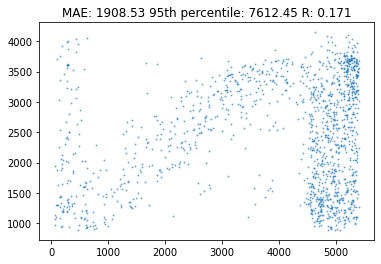

In [8]:
%matplotlib inline

plt.title(f"MAE: {round(mae_calib,2)} 95th percentile: {round(perc95_calib,2)} R: {round(cor_calib,3)}")
plt.scatter(df_test["tr"],preds_calib,s=1,alpha=0.5)
plt.show()

### full_hc_hela_hf_psms_aligned Calibration

In [11]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Call DeepLC with the downloaded models, say that we use GAM calibration
dlc = DeepLC(
        path_model=[r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5"],
        batch_num=1024000,
        pygam_calibration=True
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_calib = dlc.make_preds(seq_df=df_test)

mae_calib = sum(abs(df_test["tr"]-preds_calib))/len(df_test["tr"].index)
perc95_calib = np.percentile(abs(df_test["tr"]-preds_calib),95)*2
cor_calib = pearsonr(df_test["tr"],preds_calib)[0]

14/14 [==============================] - 13s 907ms/step


Exception ignored in: <bound method _EagerDefinedFunctionDeleter.__del__ of <tensorflow.python.eager.function._EagerDefinedFunctionDeleter object at 0x7f6688659dc8>>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_predict_function_27122'.


14/14 [==============================] - 15s 1s/step


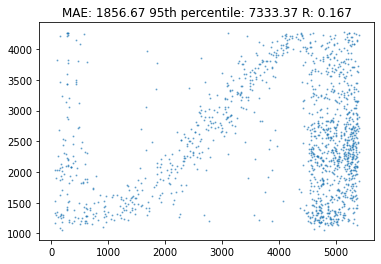

In [12]:
%matplotlib inline

plt.title(f"MAE: {round(mae_calib,2)} 95th percentile: {round(perc95_calib,2)} R: {round(cor_calib,3)}")
plt.scatter(df_test["tr"],preds_calib,s=1,alpha=0.5)
plt.show()

### Transfer learning with full_hc_train_pxd001468 models

In [13]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5"],
    freeze_layers=False,
    n_epochs=50,
    freeze_after_concat=1
)

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_transflearn = dlc.make_preds(seq_df=df_test)

mae_transflearn = sum(abs(df_test["tr"]-preds_transflearn))/len(df_test["tr"].index)
perc95_transflearn = np.percentile(abs(df_test["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(df_test["tr"],preds_transflearn)[0]

Exception ignored in: <bound method _EagerDefinedFunctionDeleter.__del__ of <tensorflow.python.eager.function._EagerDefinedFunctionDeleter object at 0x7f68236e8e88>>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_predict_function_47056'.


Epoch 1/50
473/473 [==============================] - 42s 86ms/step - loss: 0.2455 - mean_absolute_error: 0.2125 - val_loss: 0.1887 - val_mean_absolute_error: 0.1562
Epoch 2/50
473/473 [==============================] - 41s 87ms/step - loss: 0.1783 - mean_absolute_error: 0.1462 - val_loss: 0.1895 - val_mean_absolute_error: 0.1578
Epoch 3/50
473/473 [==============================] - 41s 86ms/step - loss: 0.1704 - mean_absolute_error: 0.1390 - val_loss: 0.1682 - val_mean_absolute_error: 0.1370
Epoch 4/50
473/473 [==============================] - 41s 86ms/step - loss: 0.1614 - mean_absolute_error: 0.1305 - val_loss: 0.2034 - val_mean_absolute_error: 0.1727
Epoch 5/50
473/473 [==============================] - 39s 83ms/step - loss: 0.1577 - mean_absolute_error: 0.1271 - val_loss: 0.2156 - val_mean_absolute_error: 0.1851
Epoch 6/50
473/473 [==============================] - 39s 83ms/step - loss: 0.1576 - mean_absolute_error: 0.1273 - val_loss: 0.1913 - val_mean_absolute_error: 0.1611
Epoc

Epoch 49/50
473/473 [==============================] - 48s 102ms/step - loss: 0.1105 - mean_absolute_error: 0.0831 - val_loss: 0.1321 - val_mean_absolute_error: 0.1051
Epoch 50/50
473/473 [==============================] - 49s 103ms/step - loss: 0.1137 - mean_absolute_error: 0.0869 - val_loss: 0.1116 - val_mean_absolute_error: 0.0850
Epoch 1/50
473/473 [==============================] - 71s 148ms/step - loss: 0.3324 - mean_absolute_error: 0.2725 - val_loss: 0.3153 - val_mean_absolute_error: 0.2583
Epoch 2/50
473/473 [==============================] - 68s 143ms/step - loss: 0.2491 - mean_absolute_error: 0.1933 - val_loss: 0.2843 - val_mean_absolute_error: 0.2290
Epoch 3/50
473/473 [==============================] - 65s 136ms/step - loss: 0.2288 - mean_absolute_error: 0.1743 - val_loss: 0.2110 - val_mean_absolute_error: 0.1571
Epoch 4/50
473/473 [==============================] - 64s 135ms/step - loss: 0.2139 - mean_absolute_error: 0.1604 - val_loss: 0.2045 - val_mean_absolute_error: 0.1

Epoch 48/50
473/473 [==============================] - 73s 154ms/step - loss: 0.1402 - mean_absolute_error: 0.1047 - val_loss: 0.1538 - val_mean_absolute_error: 0.1182
Epoch 49/50
473/473 [==============================] - 72s 153ms/step - loss: 0.1305 - mean_absolute_error: 0.0959 - val_loss: 0.1432 - val_mean_absolute_error: 0.1091
Epoch 50/50
14/14 [==============================] - 14s 962ms/step


Exception ignored in: <bound method _EagerDefinedFunctionDeleter.__del__ of <tensorflow.python.eager.function._EagerDefinedFunctionDeleter object at 0x7f6823e12c18>>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_train_function_108410'.
Exception ignored in: <bound method _EagerDefinedFunctionDeleter.__del__ of <tensorflow.python.eager.function._EagerDefinedFunctionDeleter

14/14 [==============================] - 17s 1s/step


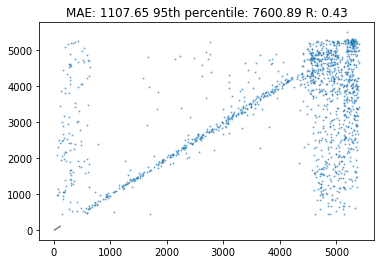

In [14]:
%matplotlib inline

plt.title(f"MAE: {round(mae_transflearn,2)} 95th percentile: {round(perc95_transflearn,2)} R: {round(cor_transflearn,3)}")
plt.scatter(df_test["tr"],preds_transflearn,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

### Transfer learning with full_hc_hela_hf_psms_aligned models

In [15]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5"],
    freeze_layers=False,
    n_epochs=10,
    freeze_after_concat=1
)

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_transflearn = dlc.make_preds(seq_df=df_test)

mae_transflearn = sum(abs(df_test["tr"]-preds_transflearn))/len(df_test["tr"].index)
perc95_transflearn = np.percentile(abs(df_test["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(df_test["tr"],preds_transflearn)[0]

Exception ignored in: <bound method _EagerDefinedFunctionDeleter.__del__ of <tensorflow.python.eager.function._EagerDefinedFunctionDeleter object at 0x7f6909a42228>>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_predict_function_240042'.


Epoch 1/10
473/473 [==============================] - 47s 95ms/step - loss: 0.1827 - mean_absolute_error: 0.1576 - val_loss: 0.1515 - val_mean_absolute_error: 0.1269
Epoch 2/10
473/473 [==============================] - 45s 95ms/step - loss: 0.1368 - mean_absolute_error: 0.1126 - val_loss: 0.1438 - val_mean_absolute_error: 0.1200
Epoch 3/10
473/473 [==============================] - 47s 98ms/step - loss: 0.1274 - mean_absolute_error: 0.1039 - val_loss: 0.1245 - val_mean_absolute_error: 0.1012
Epoch 4/10
473/473 [==============================] - 47s 98ms/step - loss: 0.1217 - mean_absolute_error: 0.0986 - val_loss: 0.1298 - val_mean_absolute_error: 0.1068
Epoch 5/10
473/473 [==============================] - 46s 98ms/step - loss: 0.1174 - mean_absolute_error: 0.0945 - val_loss: 0.1147 - val_mean_absolute_error: 0.0919
Epoch 6/10
473/473 [==============================] - 47s 100ms/step - loss: 0.1123 - mean_absolute_error: 0.0898 - val_loss: 0.1194 - val_mean_absolute_error: 0.0971
Epo

Exception ignored in: <bound method _EagerDefinedFunctionDeleter.__del__ of <tensorflow.python.eager.function._EagerDefinedFunctionDeleter object at 0x7f6822454678>>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/rt/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_map_grab_batch_275892'.
Exception ignored in: <bound method _EagerDefinedFunctionDeleter.__del__ of <tensorflow.python.eager.function._EagerDefinedFunctio

14/14 [==============================] - 17s 1s/step


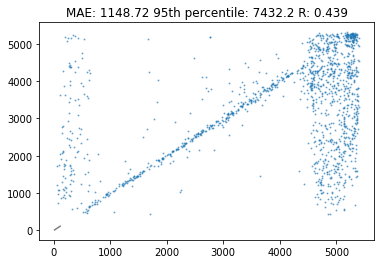

In [16]:
%matplotlib inline

plt.title(f"MAE: {round(mae_transflearn,2)} 95th percentile: {round(perc95_transflearn,2)} R: {round(cor_transflearn,3)}")
plt.scatter(df_test["tr"],preds_transflearn,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

### Transfer learning with full_hc_hela_hf_psms_aligned models(500<tr<4100)

In [21]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

df_train = df_train[(500< df_train["tr"]) & (df_train["tr"]< 4500)]
df_test = df_test[(500< df_test["tr"]) & (df_test["tr"]< 4500)]

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5",r"/mnt/nfs/wangd/DeepLC/Model/PXD001468_models/full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5"],
    n_epochs=50,
    freeze_after_concat=1
)

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_transflearn = dlc.make_preds(seq_df=df_test)

mae_transflearn = sum(abs(df_test["tr"]-preds_transflearn))/len(df_test["tr"].index)
perc95_transflearn = np.percentile(abs(df_test["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(df_test["tr"],preds_transflearn)[0]

2023-03-14 08:48:40.483780: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-14 08:49:09.953394: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-14 08:49:11.059792: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
468/468 [==============================] - 42s 88ms/step - loss: 0.1844 - mean_absolute_error: 0.1596 - val_loss: 0.1738 - val_mean_absolute_error: 0.1494
Epoch 2/50
468/468 [==============================] - 41s 88ms/step - loss: 0.1421 - mean_absolute_error: 0.1181 - val_loss: 0.1432 - val_mean_absolute_error: 0.1197
Epoch 3/50
468/468 [==============================] - 40s 86ms/step - loss: 0.1320 - mean_absolute_error: 0.1087 - val_loss: 0.1317 - val_mean_absolute_error: 0.1087
Epoch 4/50
468/468 [==============================] - 41s 88ms/step - loss: 0.1226 - mean_absolute_error: 0.0998 - val_loss: 0.1308 - val_mean_absolute_error: 0.1082
Epoch 5/50
468/468 [==============================] - 38s 82ms/step - loss: 0.1184 - mean_absolute_error: 0.0960 - val_loss: 0.1660 - val_mean_absolute_error: 0.1436
Epoch 6/50
468/468 [==============================] - 40s 85ms/step - loss: 0.1192 - mean_absolute_error: 0.0968 - val_loss: 0.1296 - val_mean_absolute_error: 0.1073
Epoc

468/468 [==============================] - 41s 87ms/step - loss: 0.0842 - mean_absolute_error: 0.0648 - val_loss: 0.1073 - val_mean_absolute_error: 0.0878
Epoch 1/50
468/468 [==============================] - 53s 110ms/step - loss: 0.1726 - mean_absolute_error: 0.1406 - val_loss: 0.1642 - val_mean_absolute_error: 0.1331
Epoch 2/50
468/468 [==============================] - 52s 110ms/step - loss: 0.1368 - mean_absolute_error: 0.1064 - val_loss: 0.1381 - val_mean_absolute_error: 0.1083
Epoch 3/50
468/468 [==============================] - 52s 111ms/step - loss: 0.1289 - mean_absolute_error: 0.0995 - val_loss: 0.1291 - val_mean_absolute_error: 0.1003
Epoch 4/50
468/468 [==============================] - 52s 111ms/step - loss: 0.1233 - mean_absolute_error: 0.0947 - val_loss: 0.1224 - val_mean_absolute_error: 0.0940
Epoch 5/50
468/468 [==============================] - 52s 111ms/step - loss: 0.1203 - mean_absolute_error: 0.0920 - val_loss: 0.1193 - val_mean_absolute_error: 0.0914
Epoch 6/50

Epoch 49/50
468/468 [==============================] - 52s 111ms/step - loss: 0.0869 - mean_absolute_error: 0.0647 - val_loss: 0.1037 - val_mean_absolute_error: 0.0817
Epoch 50/50
468/468 [==============================] - 50s 107ms/step - loss: 0.0833 - mean_absolute_error: 0.0613 - val_loss: 0.1023 - val_mean_absolute_error: 0.0804
Epoch 1/50
468/468 [==============================] - 70s 147ms/step - loss: 0.2184 - mean_absolute_error: 0.1690 - val_loss: 0.2030 - val_mean_absolute_error: 0.1594
Epoch 2/50
468/468 [==============================] - 68s 145ms/step - loss: 0.1585 - mean_absolute_error: 0.1182 - val_loss: 0.1517 - val_mean_absolute_error: 0.1138
Epoch 3/50
468/468 [==============================] - 70s 149ms/step - loss: 0.1473 - mean_absolute_error: 0.1109 - val_loss: 0.1501 - val_mean_absolute_error: 0.1149
Epoch 4/50
468/468 [==============================] - 72s 154ms/step - loss: 0.1376 - mean_absolute_error: 0.1034 - val_loss: 0.1531 - val_mean_absolute_error: 0.1

Epoch 48/50
468/468 [==============================] - 66s 141ms/step - loss: 0.0926 - mean_absolute_error: 0.0672 - val_loss: 0.1272 - val_mean_absolute_error: 0.1016
Epoch 49/50
468/468 [==============================] - 66s 141ms/step - loss: 0.0926 - mean_absolute_error: 0.0671 - val_loss: 0.1207 - val_mean_absolute_error: 0.0956
Epoch 50/50
468/468 [==============================] - 66s 142ms/step - loss: 0.0922 - mean_absolute_error: 0.0672 - val_loss: 0.1150 - val_mean_absolute_error: 0.0900


2023-03-14 11:03:54.382929: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 14s 965ms/step


Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7fc8c0fec048>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 406, in __del__
    context.remove_function(self.name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2516, in remove_function
    context().remove_function(name)
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 1229, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_map_grab_batch_119102'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7fc8c0fec048>
Traceback (most recent call last):
  File "/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/

14/14 [==============================] - 16s 1s/step


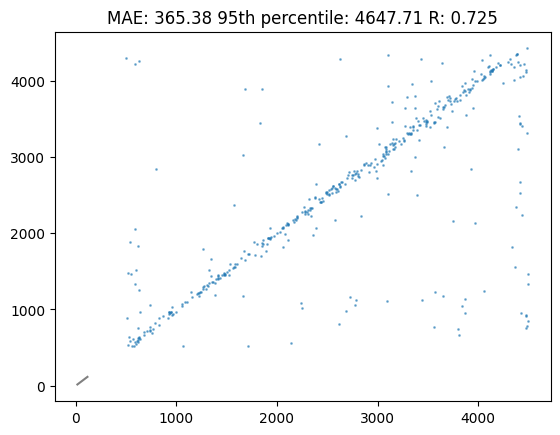

In [22]:
%matplotlib inline

plt.title(f"MAE: {round(mae_transflearn,2)} 95th percentile: {round(perc95_transflearn,2)} R: {round(cor_transflearn,3)}")
plt.scatter(df_test["tr"],preds_transflearn,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()